### Install dependencies

The first step is only necessary if running on Google colab (or if you do not have this library)

In [ ]:
!pip install shap

### Import necessary libraries

In [ ]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
from scipy.stats import loguniform, randint, uniform
from sklearn.ensemble import (
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_predict,
    permutation_test_score,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

warnings.filterwarnings("ignore")

# Set the style for the plots
sns.set_style("whitegrid")

# Use a more aesthetic palette
sns.set_palette("Set2")

In this notebook, we aim to predict the mortality of patients in the intensive care unit (ICU) using data from the eICU Collaborative Research Database. This multi-center database includes critical care patients from across the United States.

### Data Overview

We focus on initial patient information (e.g., age, sex, admission reason) and their APACHE physiological results (e.g., blood test results, muscle tone, etc.) for our analysis.

**Reference:**
Pollord et al., 2018 - [https://doi.org/10.1038/sdata.2018.178](https://doi.org/10.1038/sdata.2018.178)

In [ ]:
# Download the eICU Collaborative Research Database Demo dataset.
!wget -r -N -c -np https://physionet.org/files/eicu-crd-demo/2.0.1/apacheApsVar.csv.gz # Apache Physiological Data.
!wget -r -N -c -np https://physionet.org/files/eicu-crd-demo/2.0.1/patient.csv.gz # Patient data.

### Change working directory

This step is only necessary if running on Google colab

In [ ]:
# we need to be in the right directory to use the data
import os
os.chdir('/content/physionet.org/files/eicu-crd-demo/2.0.1')

### Data Cleaning and Preprocessing

Let's start by loading the data and taking a look at the first few rows. Here are we also do some data cleaning and preprocessing: 
- Drop unnecessary columns.
- Drop rows with missing values.
- Importantly, to anonymize the relatively identifiable patients, subjects above 89 years are grouped into the ">89" category. So, we will set them to 90 for our analysis. Therefore, please note this when interpreting patients' age.


In [3]:
patients = pd.read_csv("patient.csv.gz")
apache_physio = pd.read_csv("apacheApsVar.csv.gz").drop("apacheapsvarid", axis=1)

# Select only first visits
patients = patients[patients["unitvisitnumber"] == 1]

# Select related variables.
patients = patients[
    [
        "patientunitstayid",
        "gender",
        "age",
        "ethnicity",
        "apacheadmissiondx",
        "admissionheight",
        "hospitaldischargestatus",
        "unitadmitsource",
        "admissionweight",
    ]
]
patients = patients.rename(
    {
        "apacheadmissiondx": "diagnosis",
        "unitadmitsource": "admission_type",
        "admissionheight": "height",
        "admissionweight": "weight",
        "hospitaldischargestatus": "outcome",
    },
    axis=1,
)

# Map > 89 to 90. This was done for anonymize patients.
patients.loc[patients["age"] == "> 89", "age"] = "90"
patients["age"] = pd.to_numeric(patients["age"], errors="coerce")

# Combine patient information and APACHE physiological test results
df = patients.merge(apache_physio, on="patientunitstayid").drop(
    "patientunitstayid", axis=1
)
df = df.dropna()
df.head()

,gender,age,ethnicity,diagnosis,height,outcome,admission_type,weight,intubated,vent,...,ph,hematocrit,creatinine,albumin,pao2,pco2,bun,glucose,bilirubin,fio2
0,Female,87.0,Caucasian,"Rhythm disturbance (atrial, supraventricular)",157.5,Alive,Emergency Department,46.5,0,0,...,-1.0,37.8,1.04,-1.0,-1.0,-1.0,28.0,61,-1.0,-1
1,Male,76.0,Caucasian,"Endarterectomy, carotid",167.0,Alive,Operating Room,77.5,0,0,...,-1.0,34.1,1.14,-1.0,-1.0,-1.0,14.0,140,-1.0,-1
2,Female,34.0,Caucasian,"Overdose, other toxin, poison or drug",172.7,Alive,Emergency Department,60.3,0,0,...,-1.0,36.6,0.63,3.6,-1.0,-1.0,6.0,82,0.5,-1
3,Male,61.0,Caucasian,"GI perforation/rupture, surgery for",177.8,Alive,Operating Room,91.7,0,0,...,-1.0,40.4,1.05,-1.0,-1.0,-1.0,14.0,118,-1.0,-1
4,Female,55.0,Caucasian,"Endarterectomy, carotid",157.5,Alive,Operating Room,72.5,0,0,...,-1.0,-1.0,-1.00,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1


### Visualizing Data Distributions

Let's check some important distributions. 

Foremost, in our dataset, 1700 patients left the hospital alive, while 155 patients unfortunately died. This is a class imbalance problem, which we will address later.

As expected, we have older patients in the ICU, with the majority of patients being between 60-90+ years old. Additionally, male patients were admitted to the ICU more than females.


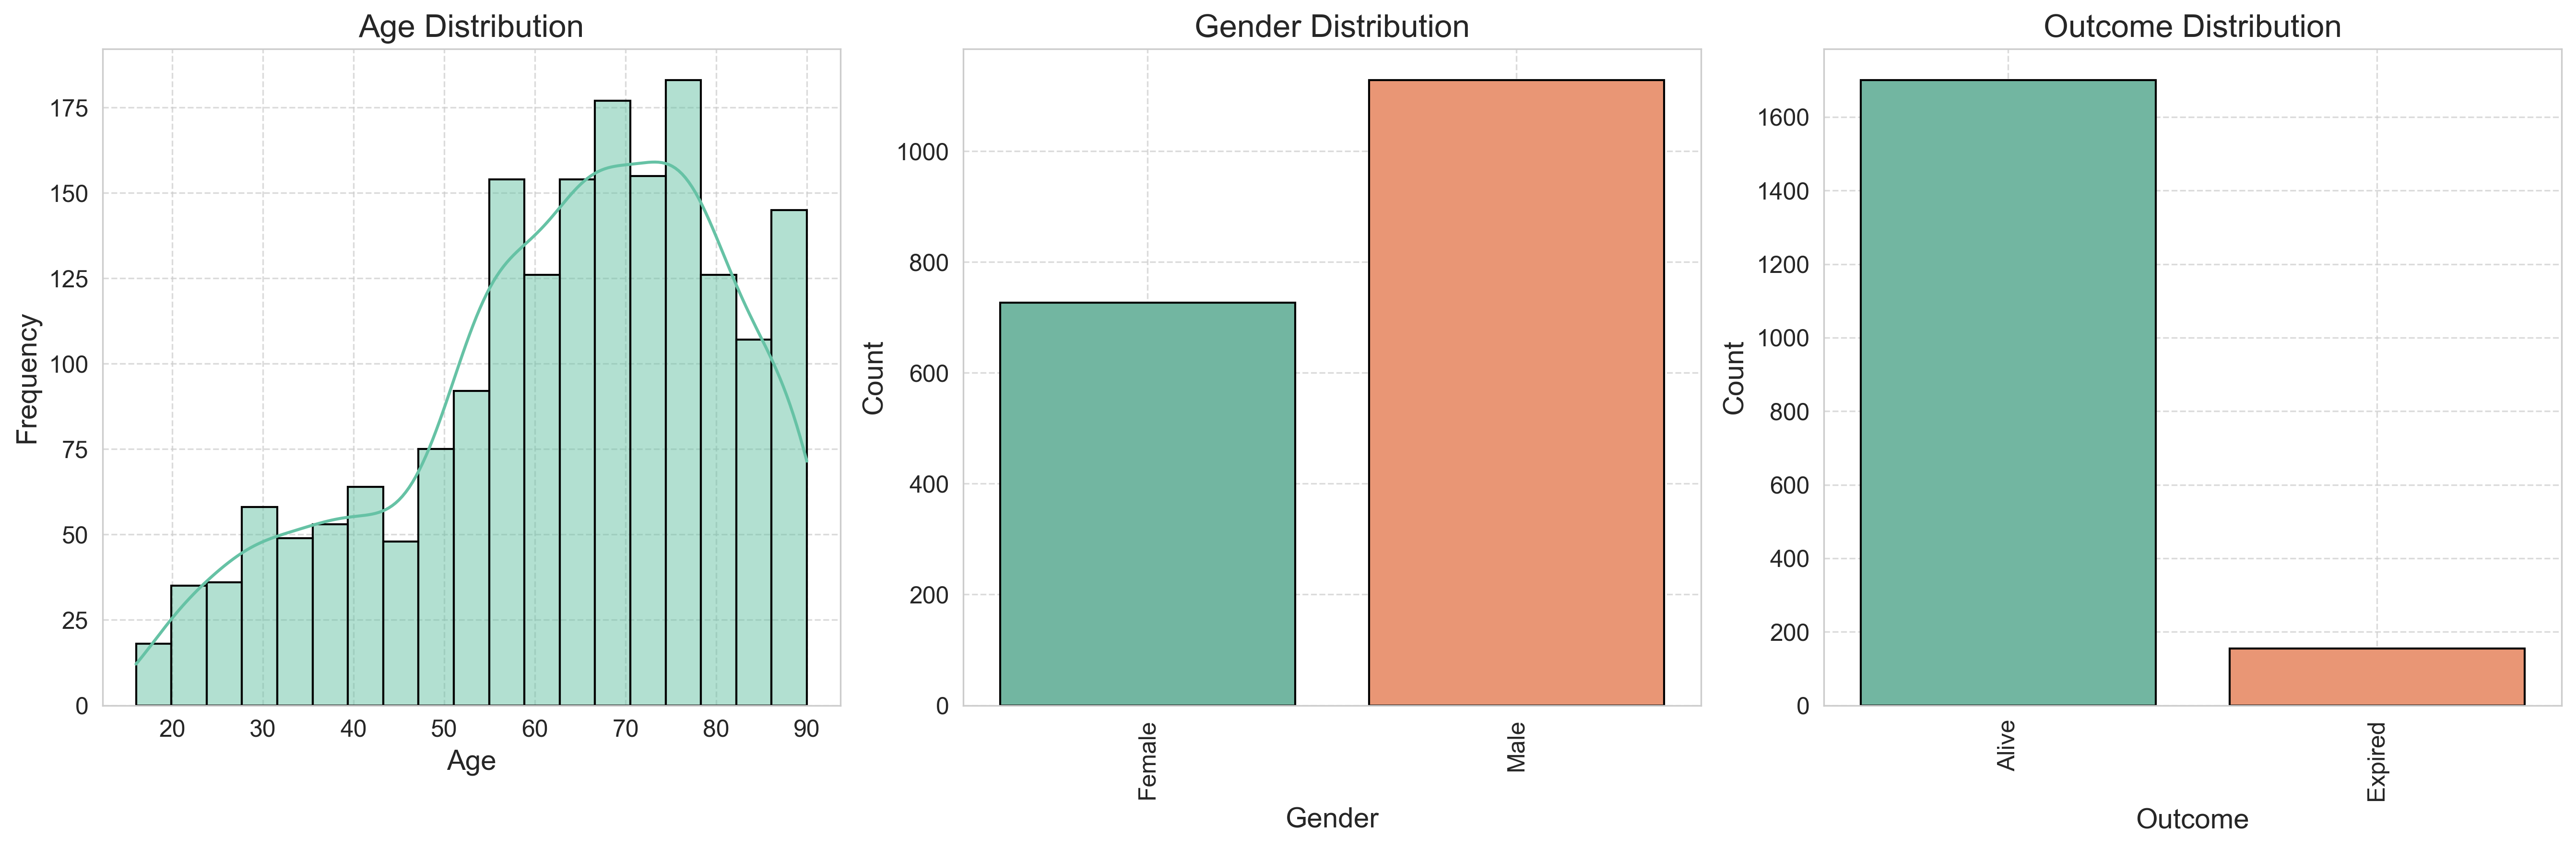

Counts:
outcome
Alive      1700
Expired     155
Name: count, dtype: int64

Percentages:
outcome
Alive      91.644205
Expired     8.355795
Name: proportion, dtype: float64


In [4]:
# Columns to plot and their corresponding plot types
columns_to_plot = ["age", "gender", "outcome"]
plot_types = ["hist", "count", "count"]


def plot_distributions(columns, plot_types, dataframe):
    # Create subplots
    fig, axes = plt.subplots(
        1, len(columns), figsize=(6 * len(columns), 6), dpi=300
    )  # 1 row, len(columns) columns

    # Plot the distributions
    for ax, column, plot_type in zip(axes, columns, plot_types):
        if plot_type == "hist":
            sns.histplot(dataframe[column], kde=True, edgecolor="black", ax=ax)
        elif plot_type == "count":
            sns.countplot(x=column, data=dataframe, edgecolor="black", ax=ax)
        ax.set_title(f"{column.capitalize()} Distribution", fontsize=16)
        ax.set_xlabel(column.capitalize(), fontsize=14)
        if plot_type == "count":
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_ylabel("Frequency" if plot_type == "hist" else "Count", fontsize=14)
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)
        ax.grid(True, linestyle="--", alpha=0.7)

    # Adjust layout
    plt.tight_layout()
    plt.show()


# Use the function to plot the distributions
plot_distributions(columns_to_plot, plot_types, df)

# Print alive and dead patients
hospitaldischargestatus_frequencies = df["outcome"].value_counts()
hospitaldischargestatus_percentages = df["outcome"].value_counts(normalize=True) * 100

print("Counts:")
print(hospitaldischargestatus_frequencies)
print("\nPercentages:")
print(hospitaldischargestatus_percentages)

Additionally, we see slightly skewed age distribution, which is also expected as we mostly have patients with "normally ranged" weight, while some patients are critically overweight. Ethnicity distribution is also in parallel with the actual US population distribution. Finally, we see that the majority of patients were admitted to the ICU directly from emergency, followed by patients admitted to the ICU following a surgery.


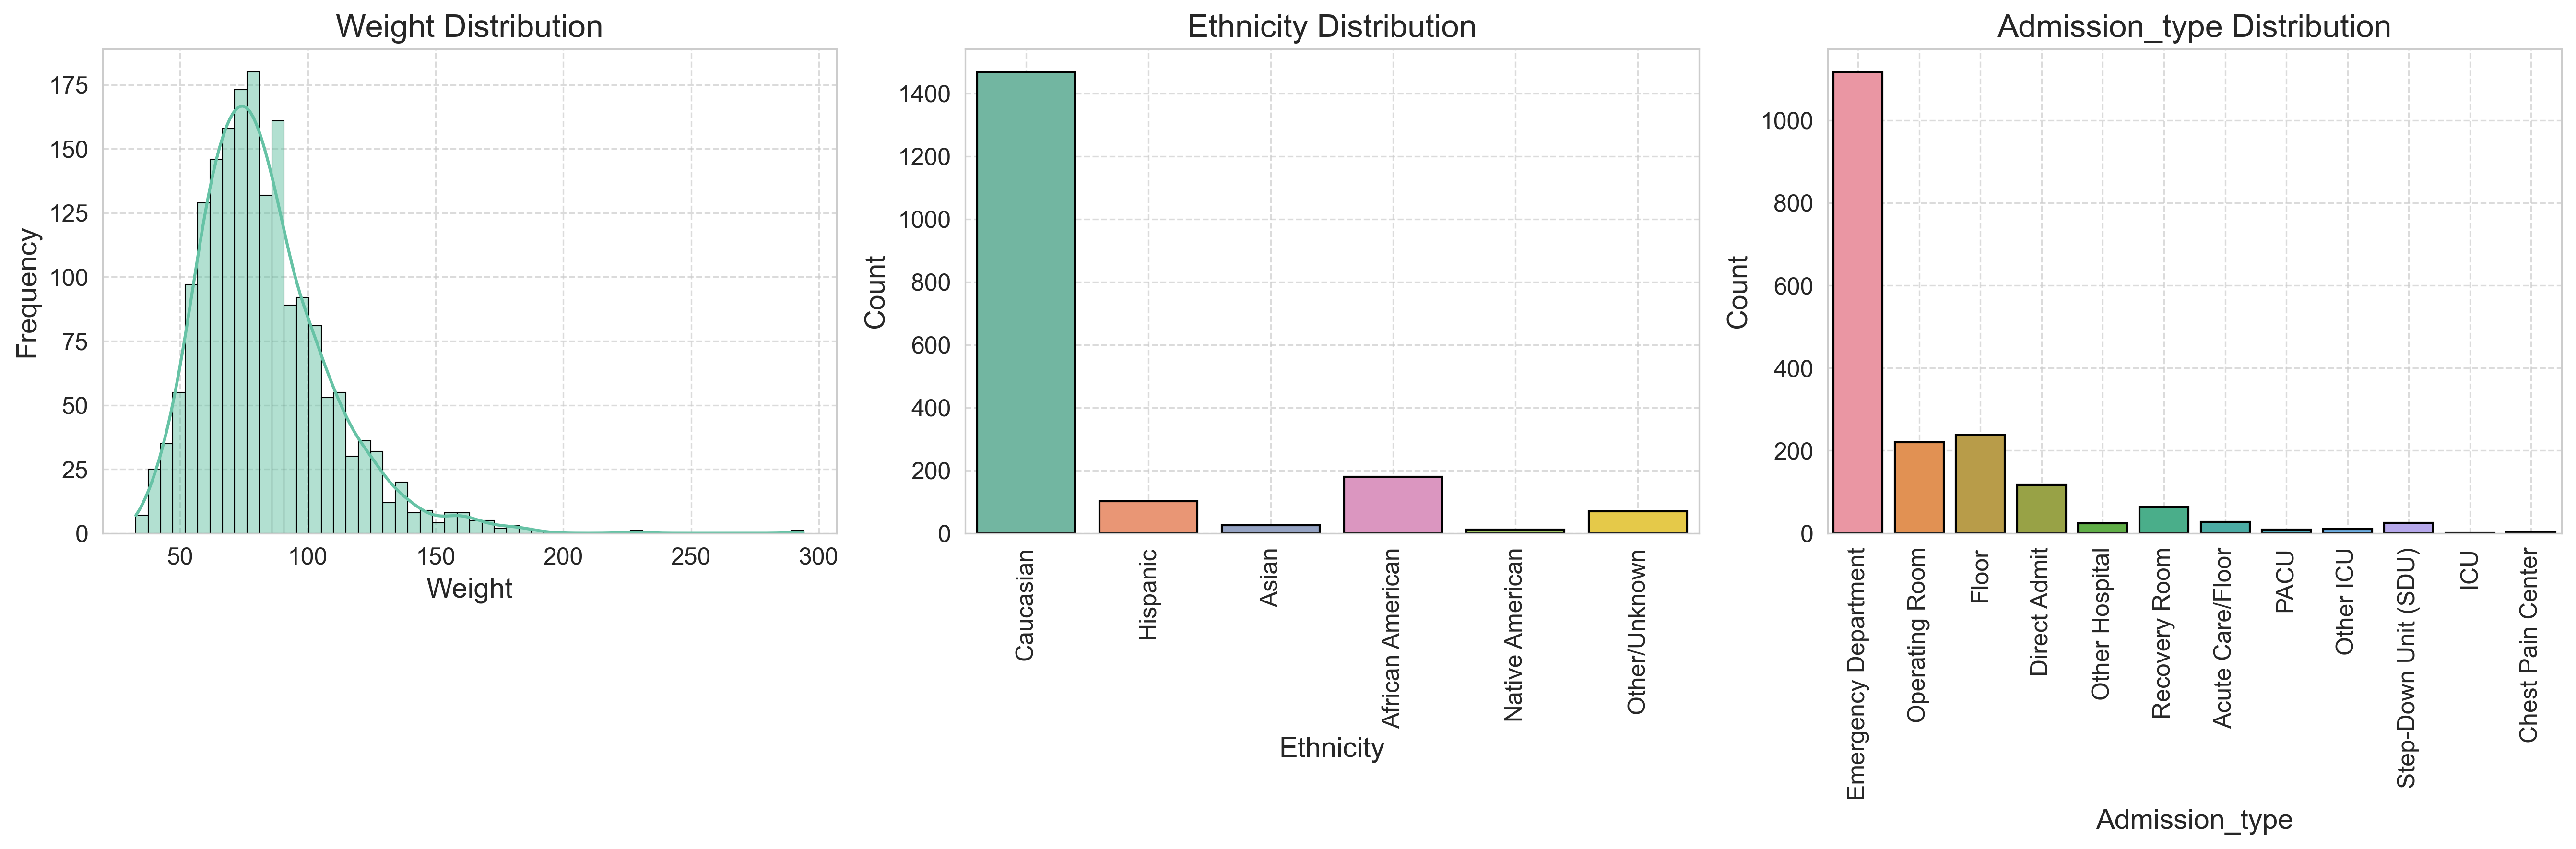

In [5]:
# Additional columns to plot and their corresponding plot types
additional_columns_to_plot = ["weight", "ethnicity", "admission_type"]
additional_plot_types = ["hist", "count", "count"]

plot_distributions(additional_columns_to_plot, additional_plot_types, df)

### Encoding Categorical Variables

Now let's move on to prediction. As a first step, we convert non-numeric columns (i.e., categorical variables, e.g., gender, ethnicity, admission type, diagnosis) to numeric values. We will use the `LabelEncoder` for this purpose.

In [6]:
# Initialize the label encoder
label_encoder = LabelEncoder()

# Encode all columns with "object" dtype
for column in df.select_dtypes(include=["object"]).columns:
    df[column] = label_encoder.fit_transform(df[column])

## Model Training and Evaludation

Here we spare 10% of data as a "holdout" set for final test (i.e., representing absolute external validation). This holdout set will not be used in training or validation of our model. For these steps, we will use the remaining 90% of the data. 

In [8]:
from sklearn.model_selection import train_test_split

X = df.drop("outcome", axis=1)
y = df["outcome"]
X_dev, X_holdout, y_dev, y_holdout = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

We will evaluate the following models using cross-validation:

- **Logistic Regression with L2 Regularization**
- **Random Forest**
- **Gaussian Naive Bayes**

We will use the following metrics to evaluate the models:
- **Accuracy** : The proportion of correctly predicted patients among all patients.
- **Precision** : The proportion of true positives (correctly predicted expired patients) among all predicted positives.
- **Recall** : The proportion of true positives among all actual positives (expired patients).
- **F1 Score** : The harmonic mean of precision and recall.
- **Balanced Accuracy** : Average of recall obtained on each class.

In [9]:
def compute_metrics(y_true, y_pred):
    """Compute several performance metrics given the true and predicted labels."""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1)
    recall = recall_score(y_true, y_pred, pos_label=1)
    f1 = f1_score(y_true, y_pred, pos_label=1)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)

    return {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Balanced Accuracy": balanced_accuracy,
    }


# Define the models to evaluate
models = [
    (
        "Logistic Regression",
        LogisticRegression(solver="liblinear"),
    ),  # Logistic Regression with L2 regularization
    ("Random Forest", RandomForestClassifier()),
    ("Naive Bayes", GaussianNB()),
]

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate each model using cross-validation
results = {}
for name, model in models:
    cv_preds = cross_val_predict(
        model, X_dev, y_dev, cv=cv, method="predict", n_jobs=-1
    )

    results[name] = compute_metrics(y_dev, cv_preds)

    print(
        f"{name} Performance:\n"
        f"Accuracy: {results[name]['Accuracy']:.2f}\n"
        f"Precision: {results[name]['Precision']:.2f}\n"
        f"Recall: {results[name]['Recall']:.2f}\n"
        f"F1 Score: {results[name]['F1 Score']:.2f}\n"
        f"Balanced Accuracy: {results[name]['Balanced Accuracy']:.2f}\n"
    )


Logistic Regression Performance:
Accuracy: 0.91
Precision: 0.41
Recall: 0.12
F1 Score: 0.18
Balanced Accuracy: 0.55

Random Forest Performance:
Accuracy: 0.92
Precision: 0.46
Recall: 0.04
F1 Score: 0.08
Balanced Accuracy: 0.52

Naive Bayes Performance:
Accuracy: 0.82
Precision: 0.23
Recall: 0.50
F1 Score: 0.31
Balanced Accuracy: 0.67



As we see above, Gaussian Naive Bayes performed the best. We will check if the model ranking remains the same after hyperparameter optimization. If so, we will continue with Naive Bayes. Note that we can also automatically find the best models along with hyperparameter optimization, which would also be a very good approach.

More importantly, we see a significant difference between accuracy and other metrics. This discrepancy is due to the class imbalance problem. Therefore, it is crucial to use other metrics such as *Balanced Accuracy* to correctly evaluate the model's performance.


### Hyperparameter Tuning

Let's also perform hyperparameter optimization and see if we have any improvement in prediction performance of models. We perform hyperparameter tuning using `RandomizedSearchCV` to improve model performance. To prevent data leakage, used nested-cross validation where we optimize hyperparameters in an inner loop while evaluating model performance in the outer loop.

<p align="center">
    <img src="https://vitalflux.com/wp-content/uploads/2020/08/Screenshot-2020-08-30-at-6.33.47-PM.png" alt="Nested Cross-Validation" width="600">
</p>

In [10]:
from sklearn.model_selection import RandomizedSearchCV

# Define the models and their hyperparameter grids
models = [
    (
        "Logistic Regression",
        LogisticRegression(solver="liblinear"),
        {"C": uniform(0.01, 10)},
    ),
    (
        "Random Forest",
        RandomForestClassifier(),
        {"n_estimators": randint(10, 200), "max_depth": randint(1, 20)},
    ),
    (
        "Naive Bayes",
        GaussianNB(),
        {"var_smoothing": loguniform(1e-9, 1)},
    ),
]

# Run again with hyperparameter tuning
for name, model, param_grid in models:
    random_search = RandomizedSearchCV(
        model,
        param_distributions=param_grid,
        n_iter=50,
        cv=cv,
        scoring="balanced_accuracy",
        n_jobs=-1,
        random_state=42,
    )
    cv_preds = cross_val_predict(
        random_search, X_dev, y_dev, cv=cv, method="predict", n_jobs=-1
    )

    results[name] = compute_metrics(y_dev, cv_preds)

    print(
        f"{name} Performance:\n"
        f"Accuracy: {results[name]['Accuracy']:.2f}\n"
        f"Precision: {results[name]['Precision']:.2f}\n"
        f"Recall: {results[name]['Recall']:.2f}\n"
        f"F1 Score: {results[name]['F1 Score']:.2f}\n"
        f"Balanced Accuracy: {results[name]['Balanced Accuracy']:.2f}\n"
    )


Logistic Regression Performance:
Accuracy: 0.91
Precision: 0.40
Recall: 0.12
F1 Score: 0.18
Balanced Accuracy: 0.55

Random Forest Performance:
Accuracy: 0.91
Precision: 0.42
Recall: 0.06
F1 Score: 0.10
Balanced Accuracy: 0.53

Naive Bayes Performance:
Accuracy: 0.82
Precision: 0.23
Recall: 0.49
F1 Score: 0.32
Balanced Accuracy: 0.67



### Permutation Testing

We conduct permutation testing for the Gaussian Naive Bayes model to assess the significance of our results. We shuffle the target variable (i.e., mortality) and retrain the model to see if the model's performance is significantly different from random chance.

For this purpose, we will use the `permutation_test_score` function from scikit-learn. For the purpose of this quick demo, we only use 100 permutations, but in real-world applications, we should use at least 1000 permutations. 



In [11]:
# Permutation Testing for Gaussian Naive Bayes!
warnings.filterwarnings("ignore", category=DeprecationWarning)

random_search = RandomizedSearchCV(
    GaussianNB(),
    param_distributions={"var_smoothing": loguniform(1e-9, 1)},
    n_iter=50,
    cv=cv,
    scoring="balanced_accuracy",
    n_jobs=-1,
    random_state=42,
)
true_score, perm_scores, p_value = permutation_test_score(
    random_search,
    X_dev,
    y_dev,
    cv=cv,
    n_jobs=-1,
    n_permutations=100,
    random_state=42,
    scoring="balanced_accuracy",
)

Permutation Test Results for Gaussian Naive Bayes: Balanced Accuracy: 0.67, p-value: 0.010


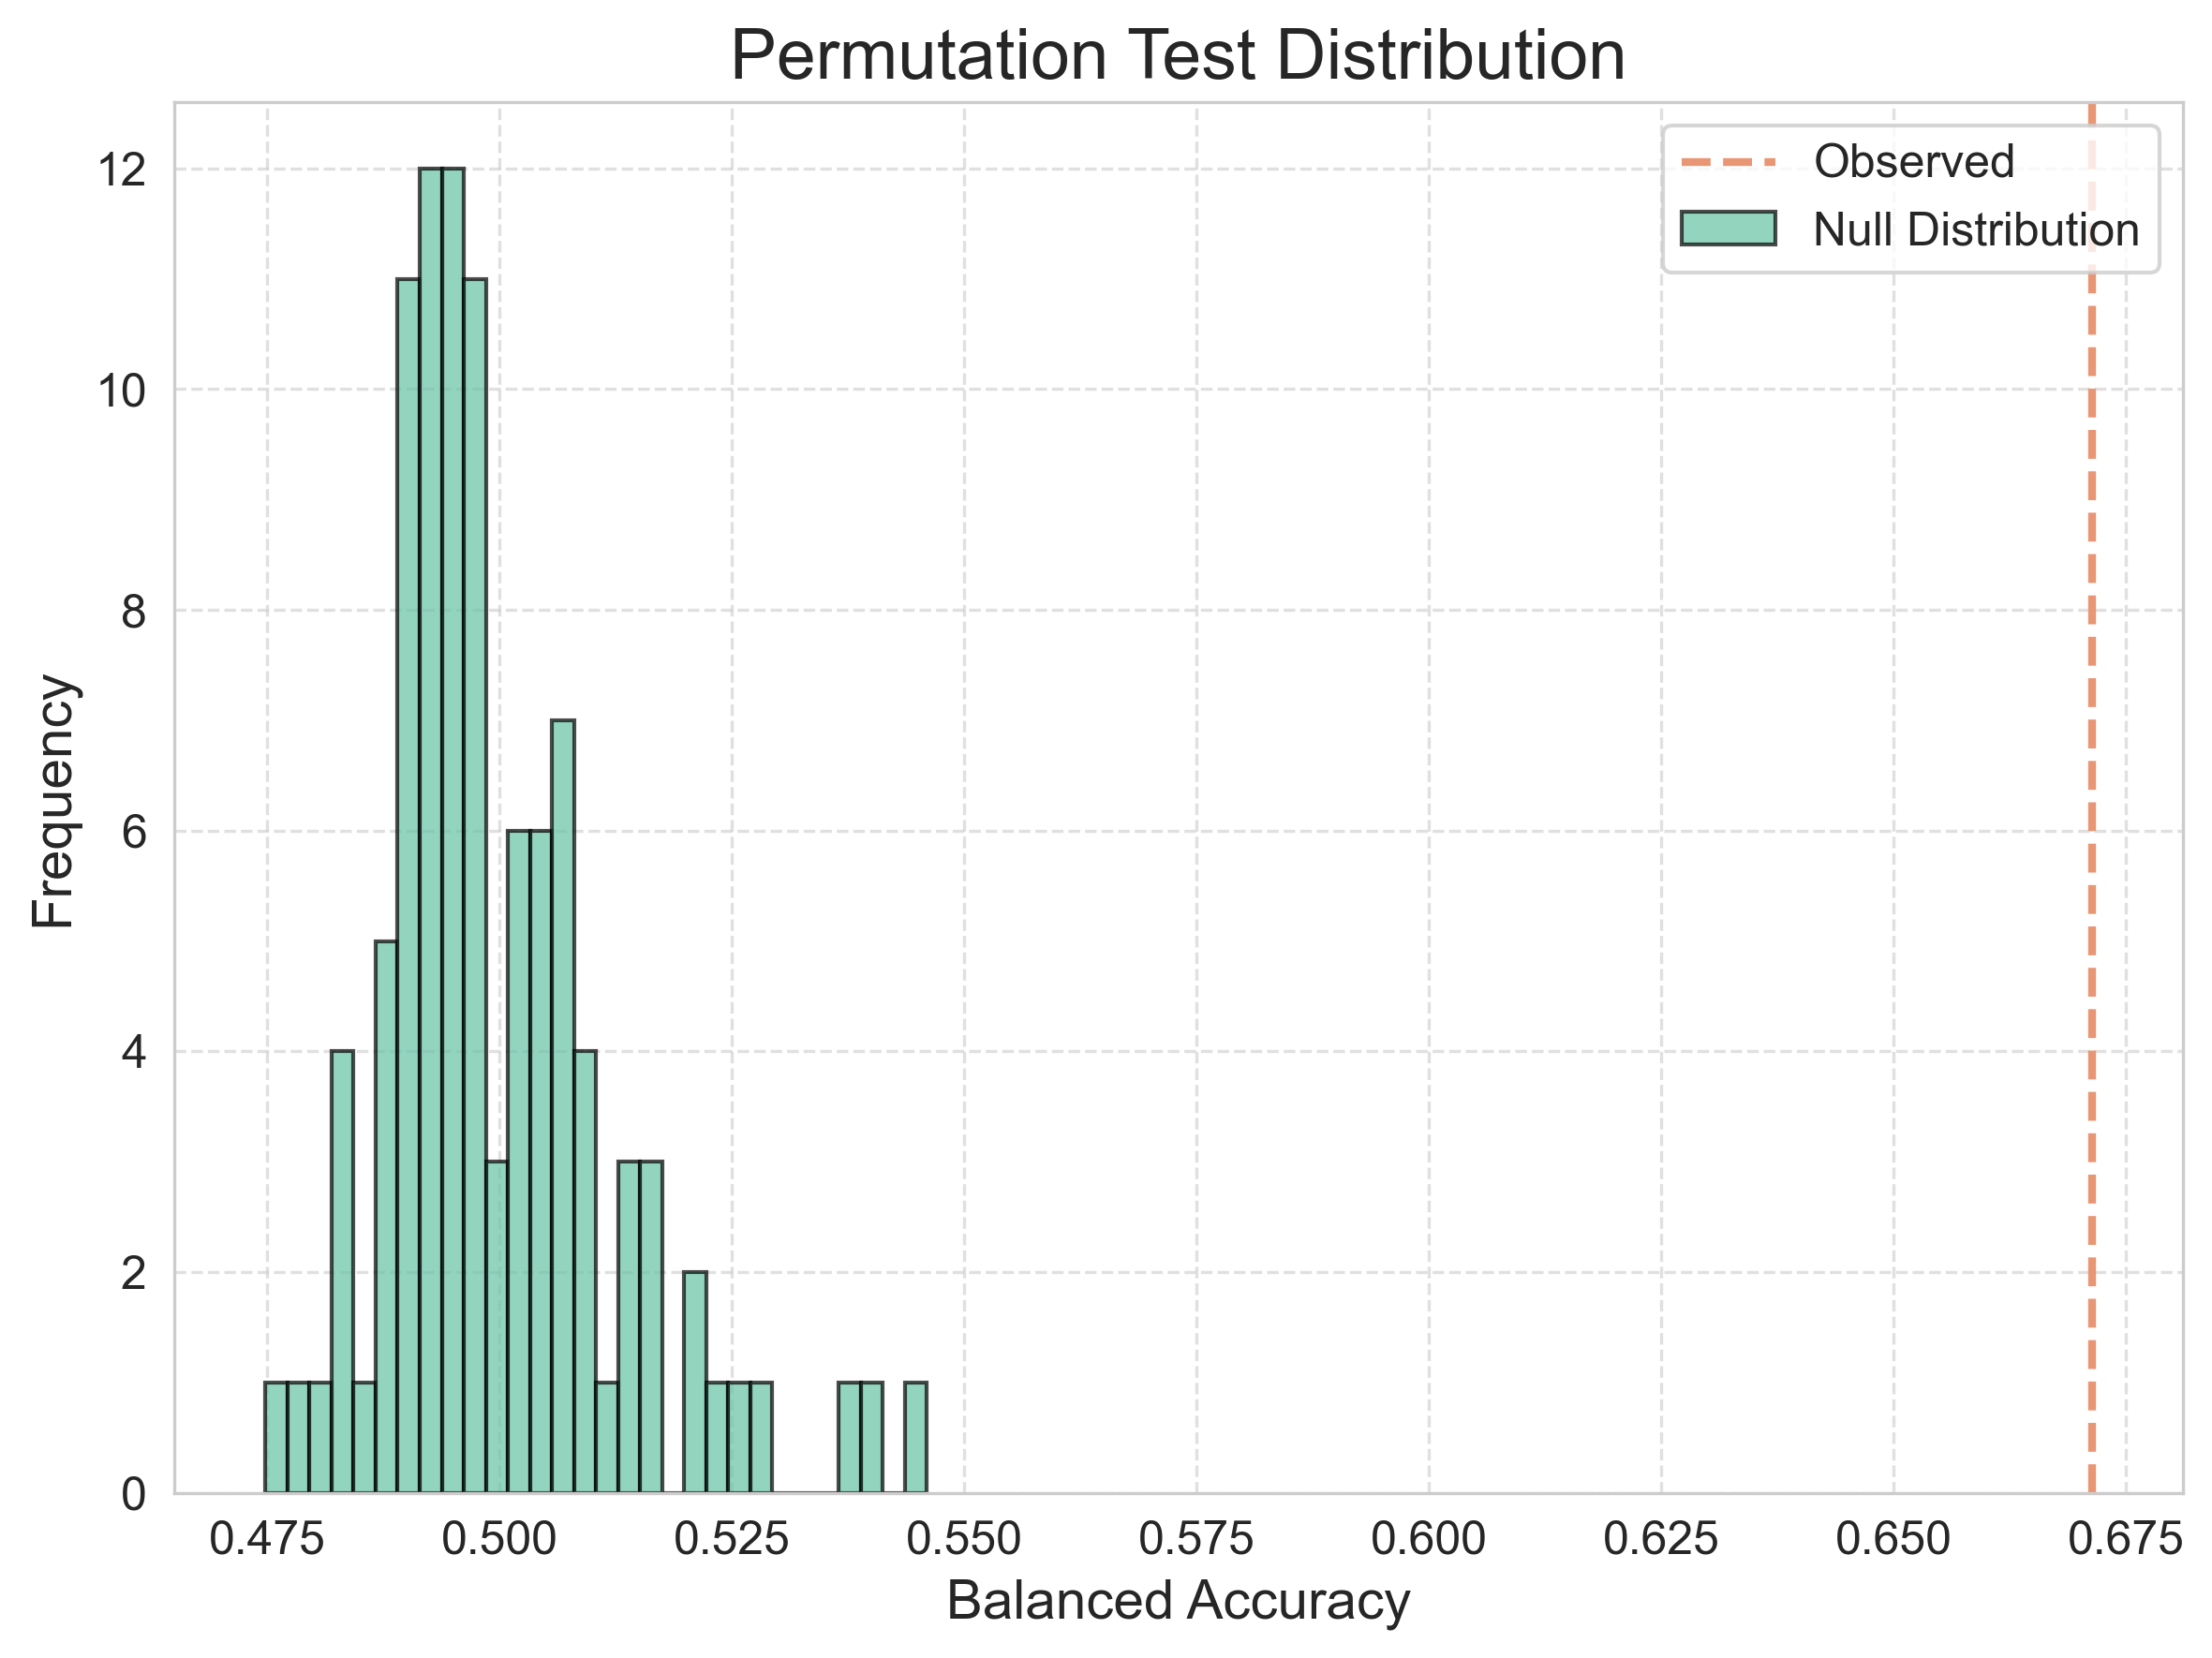

In [53]:
# Print permutation results
print(
    f"Permutation Test Results for Gaussian Naive Bayes: Balanced Accuracy: {true_score:.2f}, p-value: {p_value:.3f}"
)

# Plot the permutation distribution
plt.figure(figsize=(8, 6), dpi=300)
plt.hist(perm_scores, bins=30, alpha=0.7, edgecolor="black")
plt.axvline(true_score, color="#E99675", linestyle="dashed", linewidth=2)
plt.title("Permutation Test Distribution", fontsize=18)
plt.xlabel("Balanced Accuracy", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(
    ["Observed", "Null Distribution"], fontsize=12, loc="upper right"
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

### Final Model Evaluation

We have tested our model significantly predicts mortality on the training set. Now, we will train the model on the entire training set and evaluate it on the holdout set. This way, we can see how well our model generalizes to unseen data.

As seen below, it provides a similar performance on the holdout set, which is a good sign that our model generalizes well to unseen data.

In [13]:
# Apply to holdout set.
random_search.fit(X_dev, y_dev)
test_preds = random_search.predict(X_holdout)
scores = compute_metrics(y_holdout, test_preds)
print(
    f"Final Model Performance on Holdout Set:\n"
    f"Accuracy: {scores['Accuracy']:.2f}\n"
    f"Precision: {scores['Precision']:.2f}\n"
    f"Recall: {scores['Recall']:.2f}\n"
    f"F1 Score: {scores['F1 Score']:.2f}\n"
    f"Balanced Accuracy: {scores['Balanced Accuracy']:.2f}\n"
)

Final Model Performance on Holdout Set:
Accuracy: 0.86
Precision: 0.29
Recall: 0.44
F1 Score: 0.35
Balanced Accuracy: 0.67



### Interpretation of Feature Importance

Finally, we interpret the model's predictions by analyzing the feature importance. We use SHAP (SHapley Additive exPlanations) values to explain the model's predictions. SHAP values provide a unified measure of feature importance and can be used to explain individual predictions.

**Reference:** Lundberg, S. M., & Lee, S. I. (2017). A unified approach to interpreting model predictions. In Advances in neural information processing systems (pp. 4765-4774), https://arxiv.org/abs/1705.07874.

100%|██████████| 20/20 [00:52<00:00,  2.62s/it]


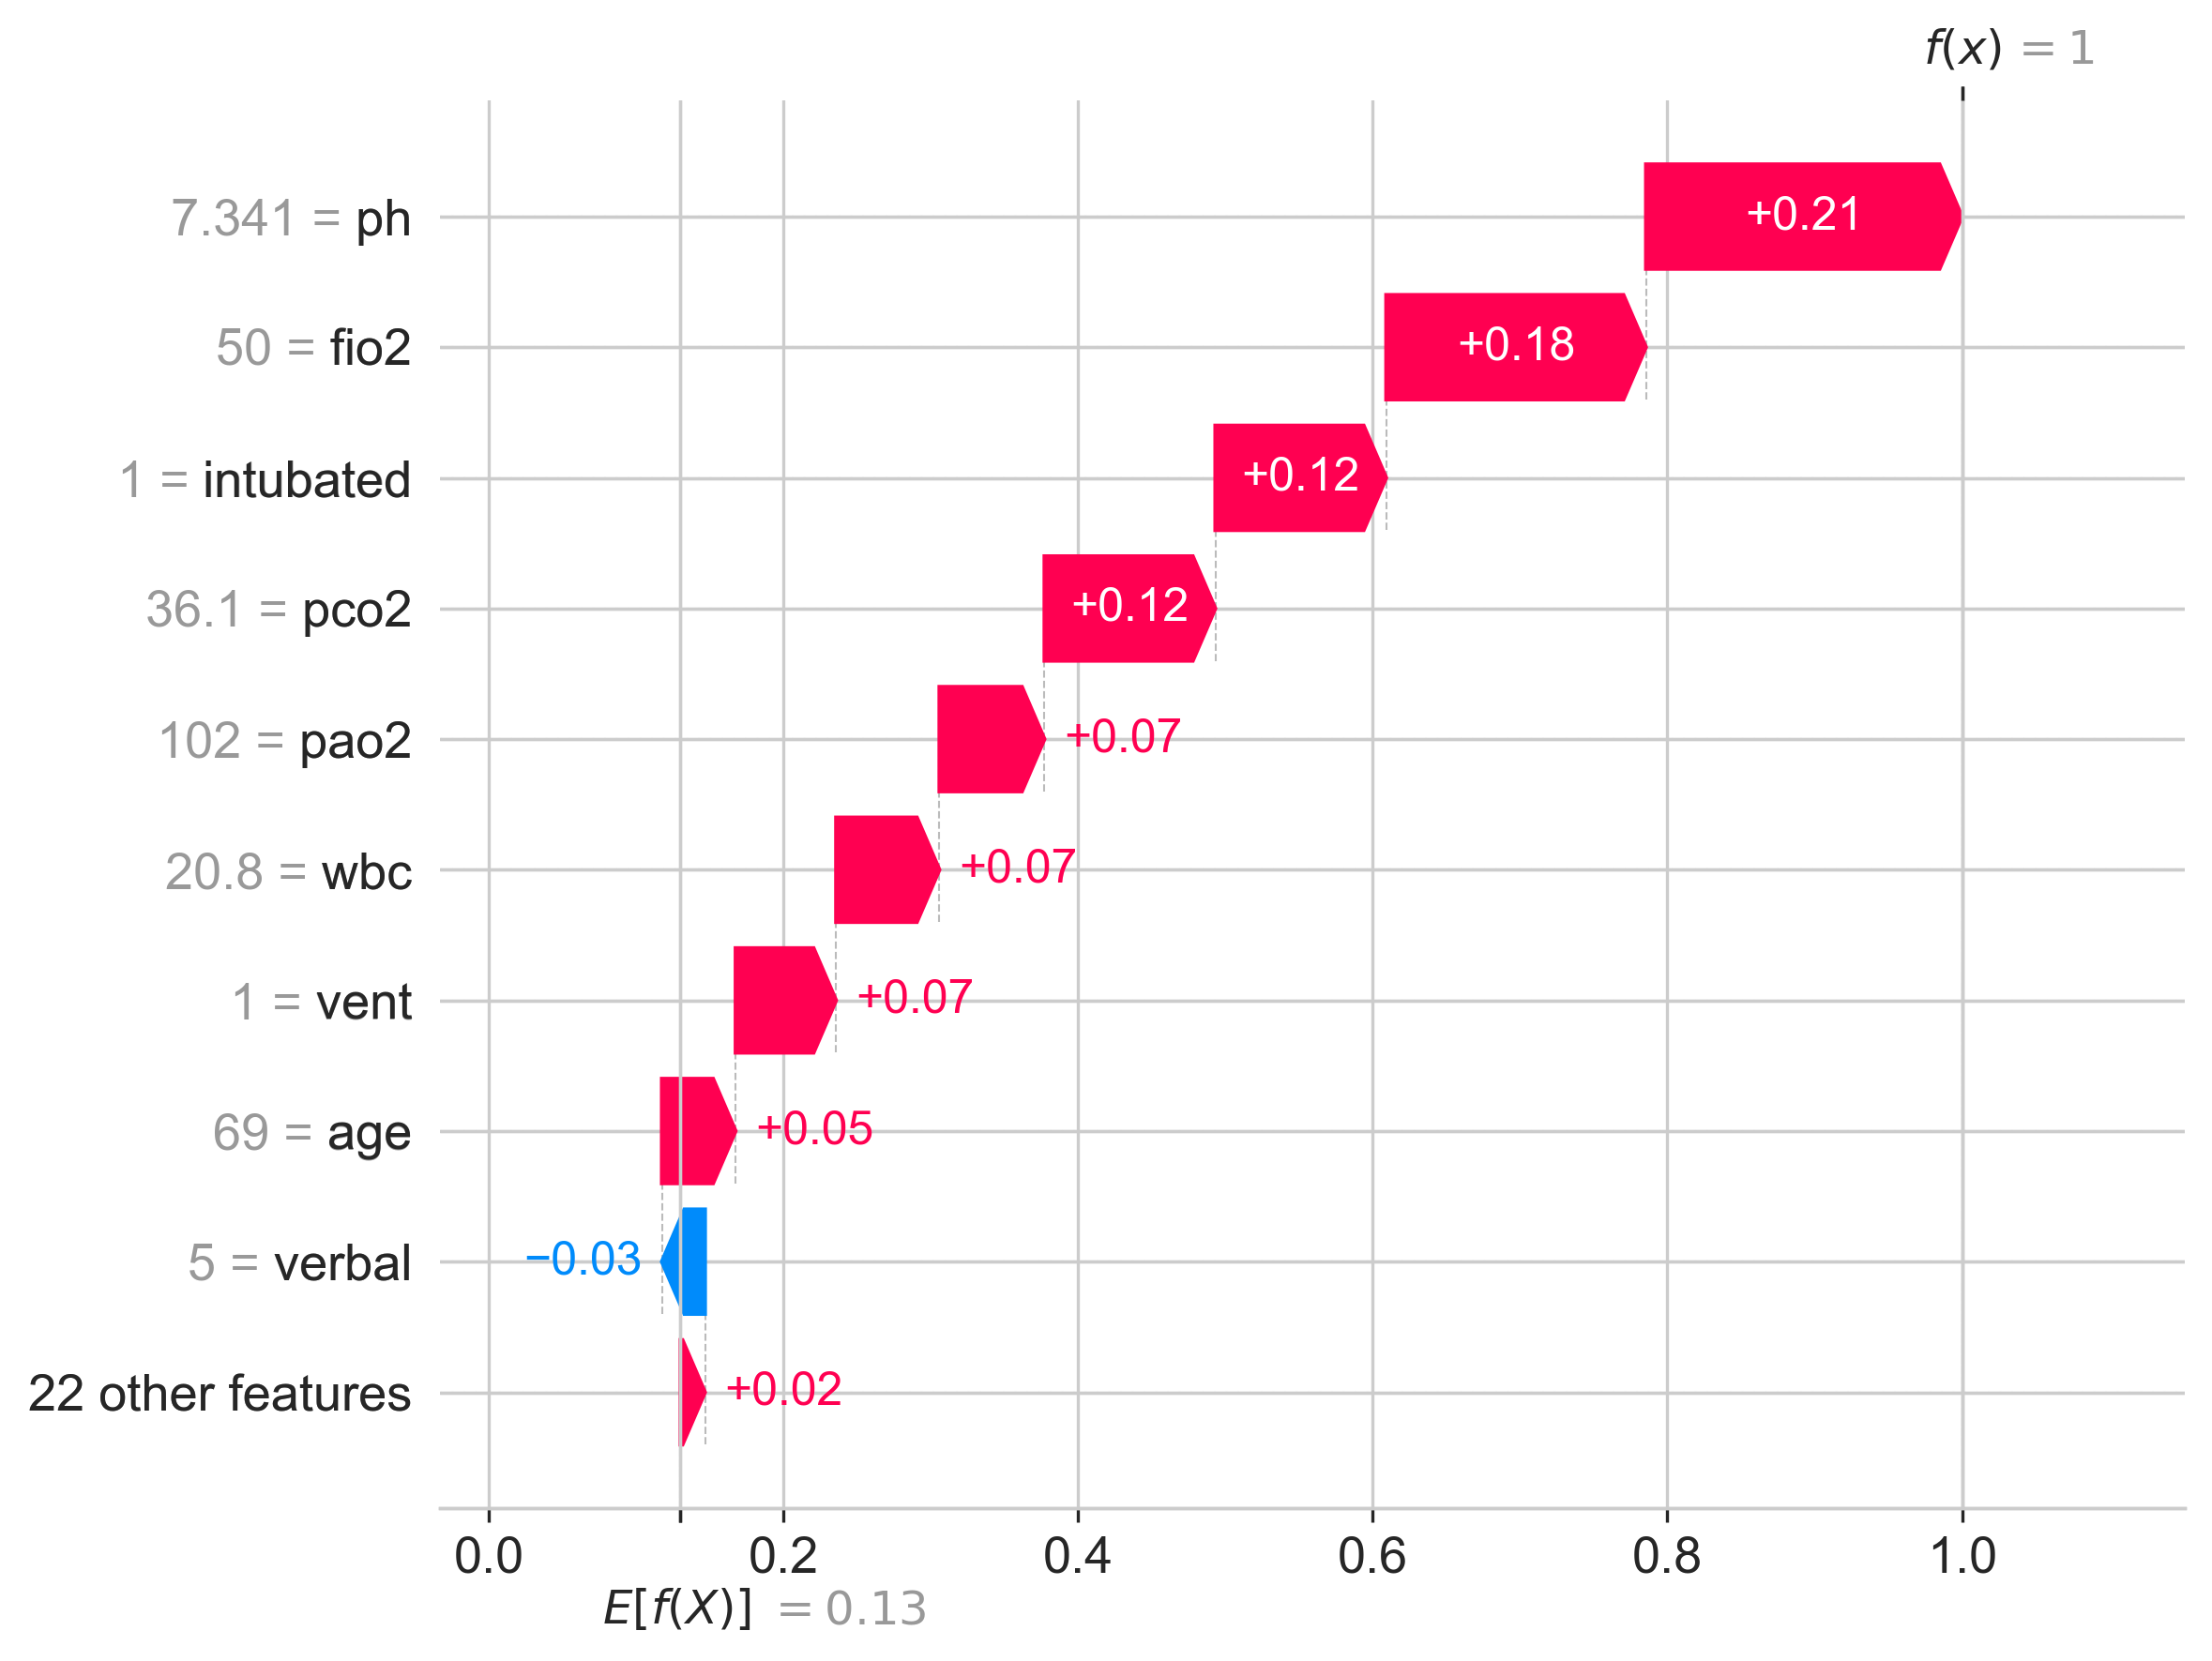

In [48]:
import numpy as np

# Initialize an array to store SHAP values
shap_values_list = []

# Run SHAP value computation 20 times
for _ in tqdm(range(20)):
    explainer = shap.Explainer(random_search.best_estimator_.predict, X_holdout)
    shap_values = explainer(X_holdout)
    shap_values_list.append(shap_values.values)

# Compute the mean SHAP values
mean_shap_values = np.mean(shap_values_list, axis=0)

# Plot SHAP summary plot for the mean SHAP values
mean_shap_values_explanation = shap.Explanation(
    values=mean_shap_values, base_values=shap_values.base_values, data=X_holdout
)
plt.figure(figsize=(10, 6), dpi=300)
shap.plots.waterfall(mean_shap_values_explanation[0], show=True)

The waterfall plot above shows 10 most important features that contribute to the model's prediction. For example, ph (blood acidity) and fio2 (fraction of inspired oxygen) are the most important features that contribute to patients' mortality. 

On y axis, next to each feature label, you can see the values that drastically changes the probability of mortality. For example, age after 69 years increases the probability of mortality, while age below 69 years decreases the probability of mortality.